The path is: /home/ucecabj/Desktop/MFI_git


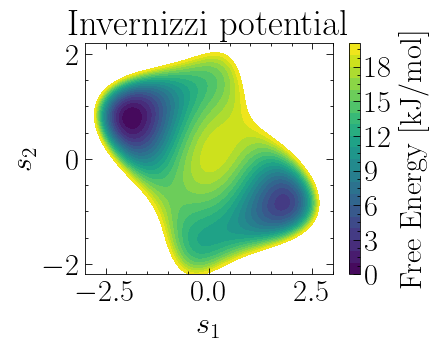

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
import time
from matplotlib import colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from matplotlib import cm, ticker
from matplotlib.colors import LinearSegmentedColormap

if 'path' in locals(): os.chdir(path)
else: os.chdir("../"); path = os.getcwd()
print("The path is:", path)

from pyMFI import MFI
from pyMFI import MFI1D
from pyMFI import run_plumed

path_manustript = path + "/Manuscript_Results/"
path_figure2 = path_manustript + "Figure2/"
path_data = path + "/DATA_examples/Invernizzi_2D_potential/"

from matplotlib import rc
plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["computer modern roman"], "font.size": 22})
boldfont = {'fontname':'Helvetica', 'fontweight':'bold'}

plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

grid = np.linspace(-3, 3, 200); 
X, Y = np.meshgrid(grid, grid)
inve_pot = 1.34549*X**4+1.90211*X**3*Y+3.92705*X**2*Y**2-6.44246*X**2-1.90211*X*Y**3+5.58721*X*Y+1.33481*X+1.34549*Y**4-5.55754*Y**2+0.904586*Y+18.5598
inve_pot = inve_pot - np.min(inve_pot)
cutoff_inve19 = np.where(inve_pot <= 19, 1, 0)
plt.figure(figsize=(4,3)); plt.contourf(X,Y,inve_pot, levels=np.arange(0, 21, 1), cmap='viridis'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel(r"$s_1$"); plt.ylabel(r"$s_2$"); plt.title("Invernizzi potential"); plt.ylim(-2.2, 2.2); plt.show()

# plt.rcParams['xtick.minor.visible'] = False
# plt.rcParams['ytick.minor.visible'] = False

# plt.rcParams['xtick.minor.visible'] = True
# plt.rcParams['ytick.minor.visible'] = True

#### (1) - Long simulation

In [10]:
!pwd

/home/ucecabj/Desktop/MFI_git/DATA_examples/Invernizzi_2D_potential


In [24]:
os.chdir(path_data)

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_long")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="positioninve_long")

#COMPUTE Mean force and weight of the simulation
results_1 = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.05, 0.05], kT = 1, 
                       min_grid= [-3, -3], max_grid = [3, 3], error_pace = 5, FES_cutoff=-1, ref_fes=inve_pot, use_weighted_st_dev = False)
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results_1

#integration on a non-periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)))

#Find Absolute devaition
AD = abs(inve_pot - FES) * cutoff
AAD = np.sum(AD)/ np.count_nonzero(cutoff)
print("\nAAD =" ,round(AAD,2))

# rename results for plotting
[FES_1, Ftot_den_1, ofe_1, AD_1, cutoff_1, time_history_1, ofe_history_1, aad_history_1, volume_history_1] = [FES, Ftot_den, ofe, AD, cutoff, time_history, ofe_history, aad_history, volume_history]

|**************************************************| 100% | Average Mean Force Error: 5.343
AAD = 0.42


### (2) - 20 short simulations

In [25]:
os.chdir(path_data)

master = []
master_patch = [[np.zeros((200,200)) for _ in range(6)]]
ofe_history_patch, aad_history_patch, volume_history_patch, time_history_patch = [], [], [], []

for simulation in np.arange(0,20): 
    
    # print('\nSimulation: ' + str(simulation))

    #Read the HILLS and position file file
    HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_" + str(int(simulation)))
    [position_x, position_y] = MFI.load_position_2D(position_name="positioninve_" + str(int(simulation)))

    #COMPUTE Mean force and weight of the simulation
    results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.05, 0.05], kT = 1, 
                         min_grid= [-3, -3], max_grid = [3, 3], error_pace=5, base_terms = master_patch[-1], ref_fes=inve_pot, use_weighted_st_dev = False)
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
    
    #store results in master_array, patch master and store result in master_patch
    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
    master_patch.append(MFI.patch_2D(master))
    
    #save error history
    ofe_history_patch += ofe_history
    aad_history_patch += aad_history
    volume_history_patch += volume_history
    time_history_patch += [element+time_history_patch[-1] for element in time_history] if len(time_history_patch) > 0 else time_history
    

#integration on a non-periodic! domain
[Xp, Yp, FES_patch] = MFI.FFT_intg_2D(master_patch[-1][2], master_patch[-1][3], min_grid= [-3, -3], max_grid = [3, 3])
cutoff_2 = MFI.get_cutoff(Ftot_den=master_patch[-1][0])

#Find Absolute devaition
AD = abs(inve_pot - FES_patch) * cutoff_2
AAD = np.sum(AD)/ np.count_nonzero(cutoff_2)
print("\nAAD:", np.round(AAD,2))

# rename results for plotting
[FES_2, Ftot_den_2, ofe_2, AD_2, cutoff_2, time_history_2, ofe_history_2, aad_history_2, volume_history_2] = [FES_patch, master_patch[-1][0], ofe, AD, cutoff_2, time_history_patch, ofe_history_patch, aad_history_patch, volume_history_patch]

|****                                              | 7% | Average Mean Force Error: 23.229

|**************************************************| 100% | Average Mean Force Error: 7.6463
AAD: 2.02


### (3) 10 MetaD simulations and 10 MetaD+HP simulations, focusing on the unexplored region in the centre

In [26]:
os.chdir(path_data)

# Only take the results from the first 10 simulations
n_old_sim = 10
master_hp = master[:-(20-n_old_sim)]
master_patch_hp = master_patch[:-(20-n_old_sim)]
ofe_history_patch_hp = ofe_history_patch[:-int((20-n_old_sim)*len(ofe_history_patch)/len(master))]
time_history_patch_hp = time_history_patch[:-int((20-n_old_sim)*len(ofe_history_patch)/len(master))]
aad_history_patch_hp = aad_history_patch[:-int((20-n_old_sim)*len(aad_history_patch)/len(master))]
volume_history_patch_hp = volume_history_patch[:-int((20-n_old_sim)*len(volume_history_patch)/len(master))]

#Add 10 MetaD simulations with static harmonic potentials
hp_centre = [[-1+0.2*i, -1+0.2*i] for i in range(10)]
kappa = 10

for simulation in range(len(hp_centre)):   
                                          
    #Read the HILLS and position file
    HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_HP_"+str(simulation))
    [position_x, position_y] = MFI.load_position_2D(position_name="positioninve_HP_"+str(simulation))
        
    #MFI with metaD and HP
    results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.05, 0.05], kT = 1, error_pace = 5, 
                         base_terms = master_patch_hp[-1], min_grid= [-3, -3], max_grid = [3, 3], ref_fes=inve_pot, use_weighted_st_dev = False,
                         hp_centre_x=hp_centre[simulation][0], hp_centre_y=hp_centre[simulation][1], hp_kappa_x=kappa, hp_kappa_y=kappa)
    
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
    
    #store results and patch with previous results
    master_hp.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
    master_patch_hp.append(MFI.patch_2D(master_hp))
        
    #save ofe history
    ofe_history_patch_hp += ofe_history
    aad_history_patch_hp += aad_history
    volume_history_patch_hp += volume_history
    time_history_patch_hp += [element+time_history_patch_hp[-1] for element in time_history]
    
#integration on a non-periodic! domain
[Xp, Yp, FES_patch_hp] = MFI.FFT_intg_2D(master_patch_hp[-1][2], master_patch_hp[-1][3], min_grid= [-3, -3], max_grid = [3, 3])
cutoff_hp = MFI.get_cutoff(Ftot_den=master_patch_hp[-1][0])

#Find Absolute devaition
AD_hp = abs(inve_pot - FES_patch_hp) * cutoff_hp
AAD_hp = np.sum(AD_hp)/(np.count_nonzero(cutoff_hp))
print("\nAAD:", round(AAD_hp,2))

# rename results for plotting
[FES_3, Ftot_den_3, ofe_3, AD_3, cutoff_3, time_history_3, ofe_history_3, aad_history_3, volume_history_3] = [FES_patch_hp, master_patch_hp[-1][0], ofe, AD_hp, cutoff_hp, time_history_patch_hp, ofe_history_patch_hp, aad_history_patch_hp, volume_history_patch_hp]

|**************************************************| 100% | Average Mean Force Error: 5.676
AAD: 1.56


### Plots

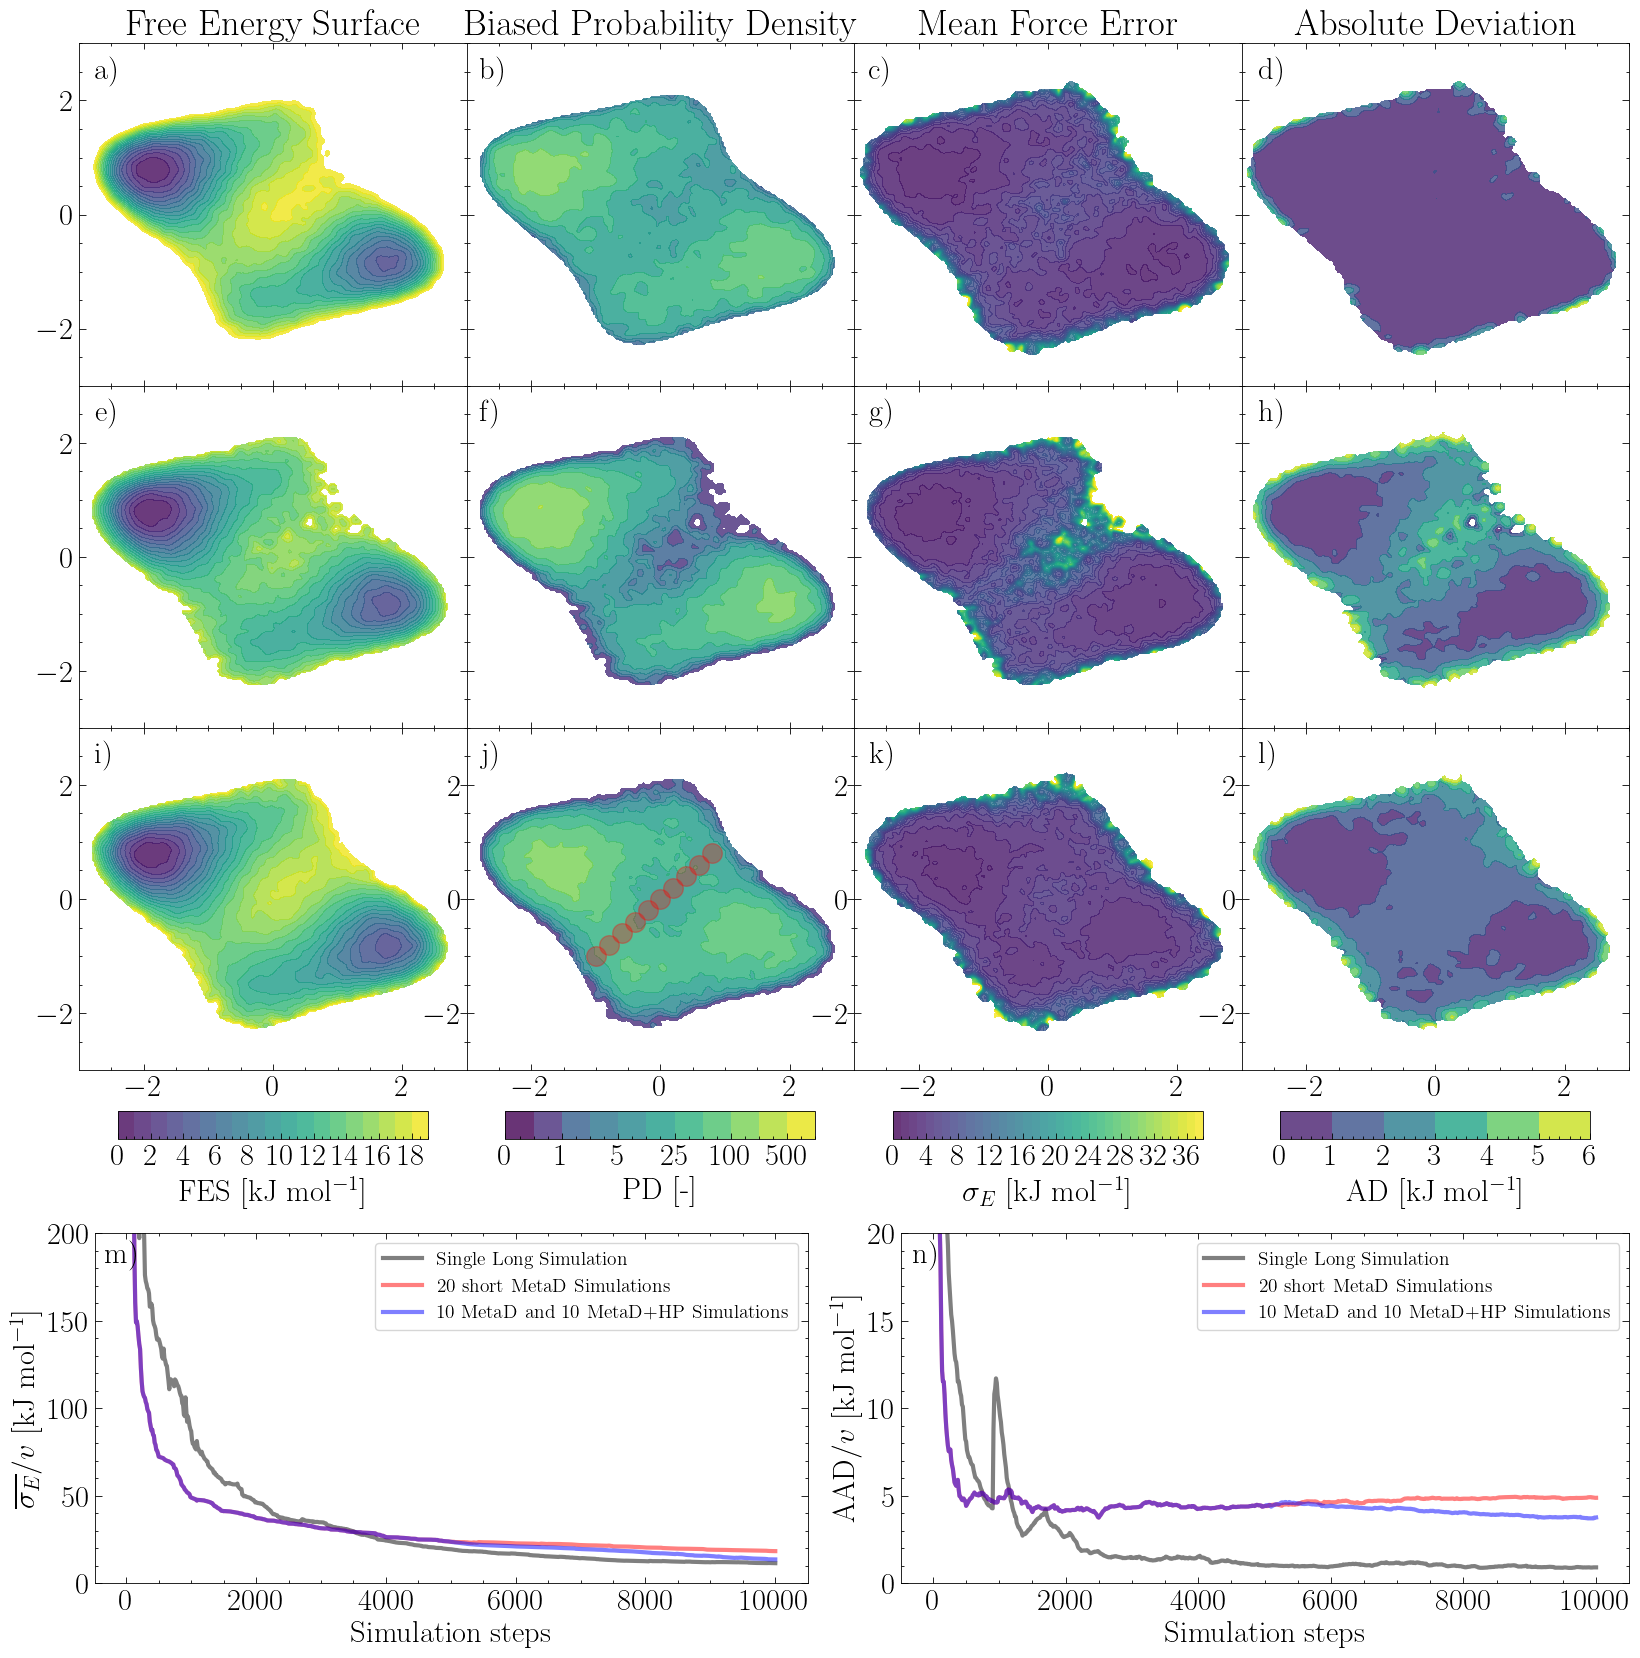

In [42]:
# Prid plot (3x4 with Ftot_den + 1x2 error)
cutoff_inve19 = np.where(inve_pot < 19, 1, 0)
plt_list = [np.where(inve_pot < 22, FES_1, np.nan), np.where(np.logical_and(Ftot_den_1>1E-1 , inve_pot < 22 ), Ftot_den_1,np.nan), MFI.zero_to_nan(ofe_1), MFI.zero_to_nan(AD_1), 
            np.where(np.logical_and(Ftot_den_2>1E-1 , inve_pot < 22 ), FES_2, np.nan), np.where(np.logical_and(Ftot_den_2>1E-1 , inve_pot < 22 ), Ftot_den_2,np.nan), np.where(np.logical_and(inve_pot < 22, ofe_2 > 0), ofe_2, np.nan), MFI.zero_to_nan(AD_2), 
            np.where(inve_pot < 22, FES_3, np.nan), np.where(np.logical_and(Ftot_den_3>1E-1 , inve_pot < 22 ), Ftot_den_3,np.nan), MFI.zero_to_nan(ofe_3), MFI.zero_to_nan(AD_3)]
levels_list = [np.arange(0, 20, 1), [0.01, 0.1, 1, 2.5, 5, 10, 25, 50, 100, 225, 500, 1000], np.arange(0, 39, 1), np.arange(0, 7, 1)]
levels_list = levels_list + levels_list + levels_list      
PD_tick_loc = [0.01, 0.055, 0.1, 0.55, 1, 1.75, 2.5, 3.75, 5, 7.5, 10, 17.5, 25, 37.5, 50, 75, 100, 162.5, 225, 362.5, 500, 750, 1000]
cbar_loc = [0,0,0,0,0,0,0,0,  -3, -2, -1, 0]
cbar_label = ["","","","","","","","",  "FES [kJ mol$^{-1}$]", "PD [-]", "$\sigma_E$ [kJ mol$^{-1}$]", "AD [kJ mol$^{-1}$]"]
title_list = ["Free Energy Surface", "Biased Probability Density", "Mean Force Error",  "Absolute Deviation"]
hp_centre = [[-1+0.2*i, -1+0.2*i] for i in range(10)]

fig = plt.figure(figsize=(20,20))
# Define the GridSpec with a spacer
gs = gridspec.GridSpec(5, 4, height_ratios=[1, 1, 1, 0.5, 1])

ax = []

# Create subplots for the first 3 rows with shared axes
for i in range(3):
    for j in range(4):
        if i == 0 and j == 0: ax.append(fig.add_subplot(gs[i, j]))
        else: ax.append(fig.add_subplot(gs[i, j], sharex=ax[0], sharey=ax[0]))

# Plot the sample data on each of the subplots
for axis in range(len(ax[:-4])):
    if axis == 1 or axis == 5 : ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8, norm=colors.LogNorm(vmin=0.1, vmax=1000))
    else: ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8)
    if axis < 4: ax[axis].set_title(title_list[axis])
    
for axis in range(len(ax))[-4:]:
    if axis == 9: 
        contour = ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8, norm=colors.LogNorm(vmin=0.1, vmax=1000))    
        axins = inset_axes(ax[axis], width="80%", height="8%", loc='lower center', bbox_to_anchor=(cbar_loc[axis], -1/5, 1, 1), bbox_transform=ax[-1].transAxes, borderpad=0)
        cbar = fig.colorbar(contour, cax=axins, orientation='horizontal', label=cbar_label[axis])
        cbar.ax.xaxis.set_minor_locator(ticker.FixedLocator(PD_tick_loc))
    else: 
        contour = ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8)    
        axins = inset_axes(ax[axis], width="80%", height="8%", loc='lower center', bbox_to_anchor=(cbar_loc[axis], -1/5, 1, 1), bbox_transform=ax[-1].transAxes, borderpad=0)
        fig.colorbar(contour, cax=axins, orientation='horizontal', label=cbar_label[axis])

for i in range(len(hp_centre)): ax[9].scatter(hp_centre[i][0], hp_centre[i][1], c="r", alpha=0.3, s=200)

gs = gridspec.GridSpec(5, 100, height_ratios=[1, 1, 1, 0.4, 1])
ax.append(fig.add_subplot(gs[4, 1:47]))
ax.append(fig.add_subplot(gs[4, 53:]))

### plot volume normalized ofe 
ax[-2].plot( time_history_1, np.asarray(ofe_history_1) / np.asarray(volume_history_1),color='black',alpha=0.5,linewidth=3,label="Single Long Simulation")
ax[-2].plot( time_history_2, np.asarray(ofe_history_2) / np.asarray(volume_history_2) ,color='red',alpha=0.5,linewidth=3,label="20 short MetaD Simulations")
ax[-2].plot( time_history_3, np.asarray(ofe_history_3) / np.asarray(volume_history_3) ,color='blue',alpha=0.5,linewidth=3,label="10 MetaD and 10 MetaD+HP Simulations")

### plot (non-normalized) ofe
# ax[-2].plot( time_history_1, np.asarray(ofe_history_1),color='black',alpha=0.5,linewidth=3,label="1 MetaD")
# ax[-2].plot( time_history_2, np.asarray(ofe_history_2) ,color='red',alpha=0.5,linewidth=3, label="20 MetaD")
# ax[-2].plot( time_history_3, np.asarray(ofe_history_3) ,color='blue',alpha=0.5,linewidth=3,label="10 MetaD and 10 MetaD+HP")

ax[-2].set_xlabel("Simulation steps"); ax[-2].set_ylabel("$\overline{\sigma_E}/ v$  [kJ mol$^{-1}$]"); ax[-2].legend(fontsize=14);
# ax[-2].set_yscale('log');
ax[-2].set_ylim(0,200); 

### plot volume normalized aad
ax[-1].plot( time_history_1, np.asarray(aad_history_1) / np.asarray(volume_history_1) ,color='black',alpha=0.5,linewidth=3,label="Single Long Simulation")
ax[-1].plot( time_history_2, np.asarray(aad_history_2) / np.asarray(volume_history_2) ,color='red',alpha=0.5,linewidth=3,label="20 short MetaD Simulations")
ax[-1].plot( time_history_3, np.asarray(aad_history_3) / np.asarray(volume_history_3) ,color='blue',alpha=0.5,linewidth=3,label="10 MetaD and 10 MetaD+HP Simulations")

### plot (non-normalized) aad 
# ax[-1].plot( time_history_1, np.asarray(aad_history_1),color='black',alpha=0.5,linewidth=3,label="1 MetaD")
# ax[-1].plot( time_history_2, np.asarray(aad_history_2),color='red',alpha=0.5,linewidth=3,  label="20 MetaD")
# ax[-1].plot( time_history_3, np.asarray(aad_history_3),color='blue',alpha=0.5,linewidth=3, label="10 MetaD and 10 MetaD+HP")

ax[-1].set_xlabel("Simulation steps"); ax[-1].set_ylabel("AAD$/v$ [kJ mol$^{-1}$]"); ax[-1].legend(fontsize=14);
# ax[-1].set_yscale('log');
ax[-1].set_ylim(0,20); 

for i in range(9):
    if i % 4 != 0: plt.setp(ax[i].get_yticklabels(), visible=False)
    if i < 8: plt.setp(ax[i].get_xticklabels(), visible=False)
    
h_text = [0.862, 0.691, 0.52, 0.27]
w_text = [0.133, 0.325, 0.52, 0.715]
fig.text(w_text[0], h_text[0], "a)"); fig.text(w_text[1], h_text[0], "b)"); fig.text(w_text[2], h_text[0], "c)"); fig.text(w_text[3], h_text[0], "d)")
fig.text(w_text[0], h_text[1], "e)"); fig.text(w_text[1], h_text[1], "f)"); fig.text(w_text[2], h_text[1], "g)"); fig.text(w_text[3], h_text[1], "h)")
fig.text(w_text[0], h_text[2], "i)"); fig.text(w_text[1], h_text[2], "j)"); fig.text(w_text[2], h_text[2], "k)"); fig.text(w_text[3], h_text[2], "l)")
fig.text(w_text[0]+0.005, h_text[3], "m)")
fig.text(w_text[2]+0.022, h_text[3], "n)")

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(path_manustript + 'Figure2/Figure2_MFI.png', dpi=600, bbox_inches='tight')
plt.show()
